# Resolved-rate control of the end-effector

The goal of this and the next laboratory is to implement a resolved-rate controller to control the end-effector. You should aim to at least finish Part 1 during Lab 5 and Part 2 during Lab 6. We recommend that you read all the instructions in Part 2 well before Lab 6.

Last laboratory, we used analytic IK to compute desired positions for the joint angles that would ensure we reach a desired position (touching the pink balls). Then we generated a straight line trajectory in joint space and used the joint PD controller to track this trajectory.

Here, we will use the fact that $$\mathcal{V}_{SO}^O = J_O(\boldsymbol{\theta}) \cdot \dot{\boldsymbol{\theta}}$$ 
to derive directly a controller acting in the end-effector space,
where $\boldsymbol{\theta} = [\theta_0, \theta_1, \theta_2]$ is the vector containing all the joint positions and $J_O$ is the Jacobian used to compute twists in Frame 0.

## Instructions
Answer all the questions below and submit a pdf with detailed answers to these questions, including the plots through Brightspace. You will also need to submit the Jupyter notebooks with the code used to answer the questions.

## Robot model
Consider the following kinematic model of the robot <img src="./3d_robot_model.png" width="700">


In [1]:
#setup nice plotting
%matplotlib notebook

# we import useful libraries
import time
import numpy as np
import matplotlib as mp
import math
import matplotlib.pyplot as plt

# we import the robot class
use_real_robot = False

if use_real_robot:
    from nyu_finger import NYUFingerReal    
else:
    from nyu_finger_simulator import NYUFingerSimulator
    
    
# here we define the global variables for the robot size
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

# Part 1: compute the end-effector Jacobian

1. Write a ``compute_jacobian`` function which computes the Jacobian of the end-effector. The computed Jacobian should be with respect to a frame located at the end-effector but oriented like the spatial frame (Frame O in the figure above). You will need to reuse the kinematics functions written in the previous laboratories.

Here make sure to return a 6x3 matrix (you will take the rows corresponding to the linear velocity in the following questions).

2. To test your Jacobian function, use your code from Lab 4 that makes the robot reach 3 different goals and compute the velocity of the end-effector at each instant of time. Compare the computed velocities with the velocities you get by numerically differentiating the end-effector positions (i.e. by computing $v[t] = \frac{x[t] - x[t-1]}{\Delta t}$). 

Here you will ignore the angular velocity and only consider the linear velocity of the end-effector. If we only look at the linear velocity of point O (i.e. the velocity of the end-effector with respect to frame O), we can decompose the Jacobian into two part (the top 3 rows are associated to the angular velocity of the end-effector and the bottom 3 are associated to the linear velocity): $$J_O(\boldsymbol{\theta}) = \begin{bmatrix} J_{O\omega} \\ J_{Ov} \end{bmatrix}$$
and we can write the velocity equation as
$$\mathcal{V}_{SO}^O = \begin{pmatrix} \omega_O \\ v_O \end{pmatrix} = \begin{bmatrix} J_{O\omega} \\ J_{Ov} \end{bmatrix} \cdot \dot{\boldsymbol{\theta}}$$

So the linear velocity of the end-effector is $$v_O = J_{Ov} \dot{\boldsymbol{\theta}}$$


3. Plot the velocities computed in question 2.

In [2]:
def skew(vector):
    sk = np.array([[0, -vector[2], vector[1]], [vector[2], 0, -vector[0]], [-vector[1], vector[0], 0]])
    return sk

def translate(vector):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    for i in range(3):
        transform[i,3] = vector[i]
    
    ### we return the object
    return transform

def rotateX(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    transform[1,1] = np.cos(angle)
    transform[1,2] = -(np.sin(angle))
    transform[2,1] = np.sin(angle)
    transform[2,2] = np.cos(angle)
    
    ### we return the object
    return transform

def rotateY(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    transform[0,0] = np.cos(angle)
    transform[2,0] = -(np.sin(angle))
    transform[0,2] = np.sin(angle)
    transform[2,2] = np.cos(angle)

    
    ### we return the object
    return transform

def rotateZ(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    transform[0,0] = np.cos(angle)
    transform[0,1] = -(np.sin(angle))
    transform[1,0] = np.sin(angle)
    transform[1,1] = np.cos(angle)

    
    ### we return the object
    return transform

def adjoint(T):
    ad = np.eye(6)
    r = T[:3, :3]
    p = T[:3, 3]
    ad[:3, :3] = r
    ad[3:, 3:] = r
    ad[3:, :3] = skew(p)@r
    return ad

In [3]:
def forward_kinematics(theta):
    # assume theta is a vector, theta[0] = theta0, theta[1] = theta1, etc.
    
    ###WRITE YOUR CODE HERE
    T_SH1  = translate([l0,  0,  0]) @ rotateX(theta[0])
    T_H1H2 = translate([ 0,  0, l3]) @ rotateZ(theta[1])
    T_H2K  = translate([ 0,-l1,  0]) @ rotateZ(theta[2])
    T_KF   = translate([ 0,-l2,  0])

    T_SF = T_SH1 @ T_H1H2 @ T_H2K @ T_KF
    
    ### we return the object
    return T_SF


In [4]:
def inverse_kinematics(x,y):
    """
    inverse kinematics function
    input (x,y) position of the fingertip
    output a list of 3D vectors which are possible solutions to the problem 
    (the list is empty if there are no solutions)
    """
    l_des = np.sqrt((x-l0)**2 + (y)**2)
    maximum = l1+l2
    
    if l_des > maximum:
        # no solutions
        return []
    
    alpha = np.arccos( (-l2**2 + l1**2 + l_des**2) / (2*l1*l_des) )
    beta = np.arctan2(y, x - l0)

    theta1_plus = np.pi/2 - alpha + beta
    theta2_plus = np.arccos( (l_des**2 - l1**2 - l2**2) / (2*l1*l2) )

    theta_plus = np.array([
        [0],
        [theta1_plus],
        [theta2_plus]
    ])
    
    if l_des == maximum:
        # one solution
        
        return [theta_plus]

    # else l_des < max: two solutions
    theta1_minus = np.pi/2 + alpha + beta
    theta2_minus = -theta2_plus
    
    theta_minus = np.array([
        [0],
        [theta1_minus],
        [theta2_minus]
    ])
    
    return [theta_plus, theta_minus]

In [5]:
def compute_trajectory(position_init, position_goal, t_init, t_goal, t):
    p_dif, t_dif = position_goal - position_init, t - t_init
    T = t_goal - t_init
    a3, a4, a5 = 10/T**3, -15/T**4, 6/T**5
    desired_position = position_init + ( a3*t_dif**3 + a4*t_dif**4 + a5*t_dif**5 ) * ( p_dif )
    desired_velocity = ( 3*a3*t_dif**2 + 4*a4*t_dif**3 + 5*a5*t_dif**4 ) * ( p_dif )
    
    # we return the answer
    return desired_position, desired_velocity

def compute_circleXY_trajectory(t):
    q_ref = np.array([0.3+0.05*math.cos(np.pi*t), -0.2+0.05*math.sin(np.pi*t), 0.])
    dq_ref = np.array([-0.05*np.pi*math.sin(np.pi*t), 0.25*np.pi*math.cos(np.pi*t), 0.])
    return q_ref, dq_ref

def compute_eight_trajectory(t):
    q_ref = np.array([0.35+0.08*math.sin(np.pi*t), -0.15+0.08*math.cos(np.pi*t)*math.sin(np.pi*t), 0.])
    dq_ref = np.array([0.08*np.pi*math.cos(np.pi*t),\
                    ((0.08*math.cos(np.pi*t))*(np.pi*math.cos(np.pi*t)) + (-0.08*np.pi*math.sin(np.pi*t))*(math.sin(np.pi*t))),\
                    0.])
    return q_ref, dq_ref

def compute_circleXZ_trajectory(t):
    q_ref = np.array([0.3+0.05*math.cos(np.pi*t), 0., -0.2+0.05*math.sin(np.pi*t)])
    dq_ref = np.array([-0.05*np.pi*math.sin(np.pi*t), 0., 0.05*np.pi*math.cos(np.pi*t)])
    return q_ref, dq_ref

In [6]:
def compute_jacobian(theta):
    J = np.zeros([6,3])

    T_SH1  = translate([l0,  0,  0]) @ rotateX(theta[0])
    T_SH2  = T_SH1 @ translate([ 0,  0, l3]) @ rotateZ(theta[1])
    T_SK   = T_SH2 @ translate([ 0,-l1,  0]) @ rotateZ(theta[2])
    T_SF   = T_SK @ translate([ 0,-l2,  0])

    J[:, 0] = adjoint(T_SH1) @ np.array([1,0,0,0,0,0])
    J[:, 1] = adjoint(T_SH2) @ np.array([0,0,1,0,0,0])
    J[:, 2] = adjoint(T_SK) @ np.array([0,0,1,0,0,0])
    
    T_OS = T_SF
    T_OS[:3,:3] = np.eye(3) #here this is setting rotation things to identity
        #at this point T_OS a transform with identify for rotation and the position parameters from T_SF
        #T_OS should have the position parameters from T_FS
        #so we negate the position column of what we have right now
    T_OS[:3, 3] *= -1     
    J_O = adjoint(T_OS) @ J
    return J_O

# Part 2: resolved rate control

## End-effector velocities

In contrast to Lab 4 where we generated trajectories in "joint space", i.e. we had a desired start and goal position for each joint, here we will directly generate trajectories for the end-effector and follow them without ever explicitly computing a desired joint position goal. We will work in "end-effector space".

Because our robot have 3 joints, away from singular configurations, the matrix $J_{Ov}$ (which is 3x3) will be invertible. It means that the joint velocity that achieves a desired end-effector velocity is
$$ \dot{\boldsymbol{\theta}} = J_{Ov}^{-1} v_O$$

## End-effector control

If we have a desired velocity we would like to achieve for the end-effector, we can then directly convert it into a desired velocity for the joints. Then we could use our joint PD controller where we would remove the P part to track this joint space velocity.

Assume we have a reference end-effector trajectory (e.g. coming from our trajectory generator that create smooth trajectories from a starting point to a desired goal with 0 velocities and accelerations at the beginning and end of the trajectories). At each instant of time, we then get $x_{ref}$ and $\dot{x}_{ref}$, the desired position and velocity of the end-effector. Our desired end-effector velocity (which is different from the target) could then be a combination between the reference velocity and an error correction term to make sure we stay on the trajectory
$$v_O = \dot{x}_{ref} + P (x_{ref} - x_{measured})$$

and so the desired joint velocities would be
$$\dot{\boldsymbol{\theta}}_{des} = J_{Ov}^{-1} \left( \dot{x}_{ref} + P (x_{ref} - x_{measured}) \right)$$

and the command sent to the robot
$$\tau = D(\dot{\boldsymbol{\theta}}_{des} - \dot{\boldsymbol{\theta}}_{measured})$$

where D is the gain we used in our previous lab for the PD control (the P in the PD controller being canceled).

## Dealing with singularities (very important!!)

The Jacobian becomes singular, i.e. non invertible, when $\theta_2 = 0$. In this case, our control law will not be well defined because the Jacobian cannot be inverted (we will see in class how to deal with this situation too later).

For now, there are 2 simple ways to handle this situation:
1. make sure the robot never reaches a singular configuration, whenever $|\theta_2| < 0.05$ stop everything,
or,
2. when $|\theta_2| < 0.05$ (i.e. we are close to a singularity), we can change the matrix to inverse to make it invertible by replacing $J_{Ov}^{-1}$ by $(J_{Ov} + \epsilon I)^{-1}$ where $\epsilon$ is a small number, e.g. 10e-4.

## Question 1: goal-reaching
1. Write a resolved-rate controller that solves the goal-reaching tasks from Lab 3 and 4 - generate end-effector trajectories using a 5th order polynomial as in Lab 4.
2. Compare the results with the results from Lab 4 - how does the end-effector trajectory change? Plot the measured end-effector position and velocity of the end-effector and the reference ones. The quantities should be graphed vs. time (use the Jacobian to get the measured end-effector velocities)
3. Run the experiment on the real robot and analyze the results.

## Question 2: other movements
1. Write a controller that can draw a circle in the x-y plane. We would like to follow the 3D end-effector trajectory $$x_{ref}(t) = \begin{pmatrix} 0.3 + 0.05\cos(\omega t) \\ -0.2 + 0.05 \sin(\omega t) \\ 0 \end{pmatrix}$$
where $\omega = \pi$ is the frequency of rotation around the circle (frequency of rotation of $0.5Hz$).
2. Plot the measured end-effector position and velocity of the end-effector and the reference ones. The quantities should be graphed vs. time (use the Jacobian to get the measured end-effector velocities)
3. Test the controller(s) on the real robot and plot the same plots as for the simulation
4. Now write a controller that can do a "figure 8" in the x-y plan $$x_{ref}(t) = \begin{pmatrix} 0.35 + 0.08\sin(\omega t) \\ -0.15 + 0.08 \cos(\omega t) \sin(\omega t) \\ 0 \end{pmatrix}$$. Show the same plots as in the previous questions.
5. Write a controller that can do a circle in the x-z plane.

In [7]:
if use_real_robot:
    # Triggers the real robot
    # Don't forget to turn on the robot first !!!
    robot = NYUFingerReal()
    motor_number = np.array([3,2,0])                               # Make sure that the motor number matches that on the robot
    robot.initialize('eth4', motor_number)
else:
    robot = NYUFingerSimulator()                                   # we can now create a robot simulation

## Reset the simulation

if not use_real_robot:
    robot.reset_state([0,0,0])

## Set some constants for the simulation

run_time = 15.                                                     # simulation length in seconds
dt = 0.001                                                         # length of one time-step
num_steps = int(run_time/dt)                                       # number of time steps
time_to_goal = 5.0                                                 # time to reach each goal
ball_number = 0                                                    # target we are aiming at
t = 0.                                                             # internal time for one target movement
eps = 10e-4                                                        # constant for singularity handling

## Choose which trajectory to follow

targets = False;
circleXY = True;
eight = False; 
circleXZ = False;

## Allocate a few vectors to collect data while we do the simulation

time = np.zeros([num_steps])                                       # keep track of time

measured_positions = np.zeros([num_steps,3])                       # measured angular position
desired_positions = np.zeros_like(measured_positions)              # desired (reference) angular position

measured_velocities = np.zeros_like(measured_positions)            # measured angular velocity
reference_velocities = np.zeros_like(measured_positions)             # desired (reference) angular velocity

measured_finger_position = np.zeros_like(measured_positions)       # measured end-effector position
desired_finger_position = np.zeros_like(measured_positions)        # desired (reference) end-effector position

measured_finger_velocity = np.zeros_like(measured_positions)       # measured end-effector position
desired_finger_velocity = np.zeros_like(measured_positions)        # desired (reference) end-effector velocity


velocities_from_jacobian = np.zeros_like(measured_positions)       # velocity of end-effector calculated from jacobian
velocities_from_motion = np.zeros_like(measured_positions)         # velocity of end-effector calcualtion from position record
measured_vel_err = np.zeros_like(measured_positions)               # error between actual end-effector velocity 
                                                                   # and end-effector velocity calculated with jacobian

desired_torques = np.zeros_like(measured_positions)                # the commands sent to the robot

## Create a list of ball positions and display them

ball_positions = [np.array([0.4,-0.156,0.02]), np.array([0.521,-0.2,0.02]), np.array([0.2,-0.225,0.02])] # TA recommended we use these ball positions

if not use_real_robot:                                             # if simulating, add targets to simulation display
    for ball in ball_positions:
        robot.add_ball(ball[0], ball[1])
else:
    # we wait
    for i in range(7500):
        robot.send_joint_torque(np.zeros([3,1]))
        robot.step()

## Loop through all time-steps
        
for i in range(num_steps):
    time[i] = dt * i                                                # get the current time and save it
    
    ## Get state of robot joints
    
    q, dq = robot.get_state()                                       # read the angular joint positions and angular joint velocities
    measured_positions[i,:] = q                                     # store angular joint position
    measured_velocities[i,:] = dq                                   # store angular joint velocities
    
    ## Calculate end-effector position
    
    pose = forward_kinematics(q)                                    # calculate end-effector position
    measured_finger_position[i,:] = pose[0:3,3]                     # store end effector position
    
    ## Calculate geometric jacobian

    jacobian = compute_jacobian(q)
    
    ## Calculate end-effector velocity using Jacobian
    
    jacobianVel = jacobian[3:] @ dq
    measured_finger_velocity[i,:] = jacobianVel;                    # store end-effector velocity
    
    ## Calculate error between actual velocity (based on robot motion) 
     # and calculation of velocity with jacobian
    
    if i>0:
        recordedVel = (measured_finger_position[i,:] - measured_finger_position[i-1,:]) / dt # actual robot velocity
        velDif = jacobianVel-recordedVel
        measured_vel_err[i,:] = velDif                              # store difference
        velocities_from_jacobian[i,:] = jacobianVel                 # store velocity from jacobian
        velocities_from_motion[i,:] = recordedVel                   # store velocity from motion
   
    ## Compute appropriate q_des and dq_des for  trajectory
 
    if (targets):
        P = np.array([1.5, 1.5, 1.5])*10                            # P gain for target tracking
        D = np.array([0.01, 0.01, 0.01])*30                         # D gain for target tracking
        
        ## Determine trajectory parameters
        
        if time[i] == 0:
            init_pos = pose[:3,3]                                   # initial position at time 0 should be robot pose
        if time_to_goal - t <= 0:
            init_pos = ball_positions[ball_number]                  # reset initial position to target position once robot has reached target
            ball_number = (ball_number + 1)                         # increment target to aim for
            t = 0                                                   # reset internal time to 0
            
        goal_pos = ball_positions[ball_number]                      # goal position is always the current target position
        
        ## Use compute trajectory function to find 
            #1 reference end-effector position and 
            #2 reference end-effector velocity
        q_ref, dq_ref = compute_trajectory(init_pos, goal_pos, 0, time_to_goal, t)                                                
    elif (circleXY):
        P = np.array([1.5, 1.5, 1.5])*50                            # P gain for circle tracking in XY plane 
        D = np.array([0.01, 0.01, 0.01])*40                         # D gain for circle tracking in XY plane
        
        ## Use compute trajectory function to find 
            #1 reference end-effector position and 
            #2 reference end-effector velocity
        q_ref, dq_ref = compute_circleXY_trajectory(time[i])
    elif (eight):
        P = np.array([1.5, 1.5, 1.5])*40                            # P gain for 8 tracking in XY plane 
        D = np.array([0.01, 0.01, 0.01])*40                         # D gain for 8 tracking in XY plane 
        
        ## Use compute trajectory function to find 
            #1 reference end-effector position and 
            #2 reference end-effector velocity
        q_ref, dq_ref = compute_eight_trajectory(time[i])
    elif (circleXZ): 
        P = np.array([1.5, 1.5, 1.5])*10                            # P gain for circle tracking in XZ plane 
        D = np.array([0.01, 0.01, 0.01])*20                         # D gain for circle tracking in XZ plane 
        
        ## Use compute trajectory function to find 
            #1 reference end-effector position and 
            #2 reference end-effector velocity
        q_ref, dq_ref = compute_circleXZ_trajectory(time[i])
    else:
        print("At least one path option must be selected.")
        break;
    
    ## Store desired end-effector position and velocity from trajectory function
      
    desired_finger_position[i,:] = q_ref                            # store end-effector desired position
    desired_finger_velocity[i,:] = dq_ref                           # store end-effector velocity    
    
    ## P control for position tracking
    
    v_O = (dq_ref + P * (q_ref - pose[:3,3]))                       # Apply P gain to end-effector velocity trakcing
    
    ## Invert jacobian
    
    if (abs(q[2]) < 0.05):                                          # handle singularity in jacobian (when q[2] < 0.05)
        invJacobian = np.linalg.inv(jacobian[3:] + eps*np.eye(3))
    else: 
        invJacobian = np.linalg.inv(jacobian[3:])
        
    ## Calculate reference joint velocities and desierd joint velocities
        
    reference_velocities[i,:] = invJacobian @ dq_ref                  # compute and store desired (reference) joint velocities
                                                                        # use this for plotting
    dtheta_des = invJacobian @ v_O                                  # desired joint velocity after P control
                                                                        # use this in D controller later and ultimatley to apply torque
    
    ## Compute desired joint positions (for plotting -not necessary for tracking)
    
    inv_kinematics_theta_all = inverse_kinematics(q_ref[0],q_ref[1]) # inverse kinematics fucntion returns all solutions
    
    if (len(inv_kinematics_theta_all) == 2):                         # if 2 solutions exist, choose the second
        inv_kinematics_theta = inv_kinematics_theta_all[1]
    elif (len(inv_kinematics_theta_all) == 1):                       # if 1 solution exists, choose it
        inv_kinematics_theta = inv_kinematics_theta_all[0]           
    else:                                                            # if no solution exists, skip to next iteration
        continue
    
    desired_positions[i,:] = np.array([inv_kinematics_theta[0,0],\
                                       inv_kinematics_theta[1,0],\
                                       inv_kinematics_theta[2,0]])   # store desired joint positions

    ## D control for velocity tracking
    
    d_error = dtheta_des - dq                                        # velocity error for all the joints
    joint_torques = D * d_error                                      # apply D gain
    desired_torques[i,:] = joint_torques                             # store applied torques
    
    ## Send torques to the robot and do one simulation step
    
    t += dt                                                          #increment t
    robot.send_joint_torque(joint_torques)
    robot.step()

<IPython.core.display.Javascript object>


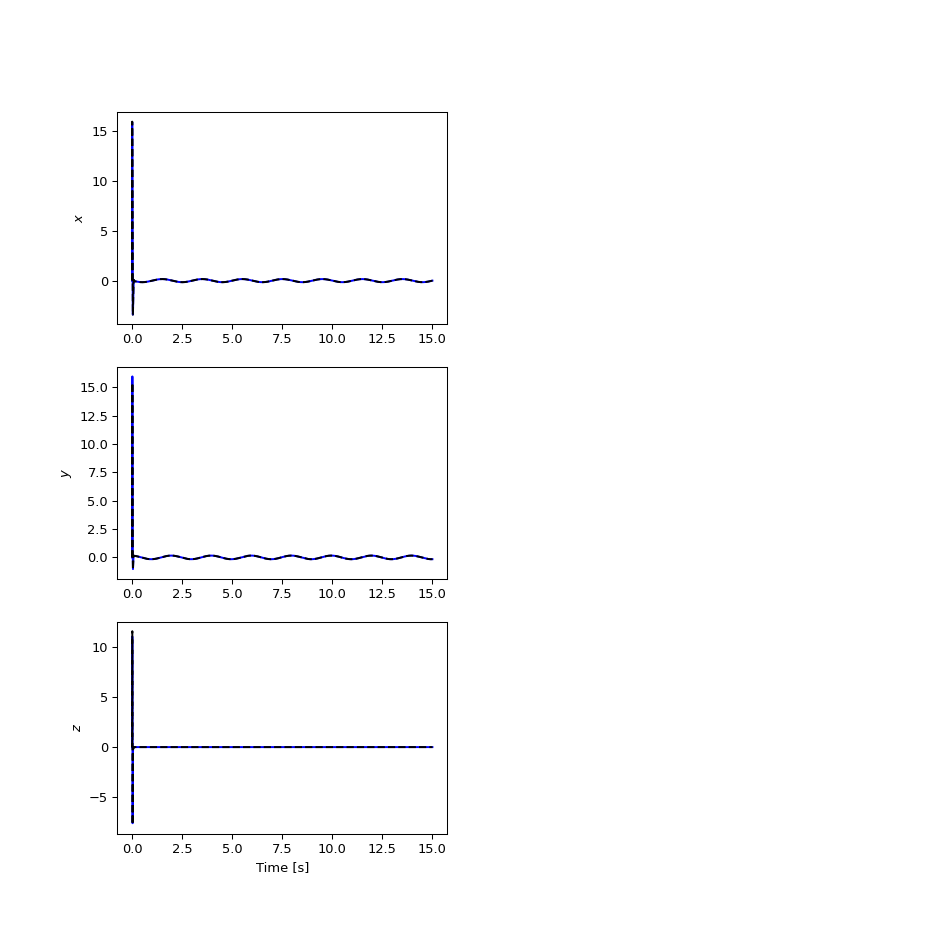

In [8]:
def plot_finger_velocities(time, jacobianVel, recordedVel):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """    
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, jacobianVel[:,0], 'b-', time, recordedVel[:,0], '--k')
    plt.ylabel(r'$x$')
    plt.subplot(3,2,3)
    plt.plot(time, jacobianVel[:,1], 'b-', time, recordedVel[:,1], '--k')
    plt.ylabel(r'$y$')
    plt.subplot(3,2,5)
    plt.plot(time, jacobianVel[:,2], 'b-', time, recordedVel[:,2], '--k')
    plt.ylabel(r'$z$')
    plt.xlabel('Time [s]')
    
plot_finger_velocities(time, velocities_from_jacobian, velocities_from_motion)

<IPython.core.display.Javascript object>


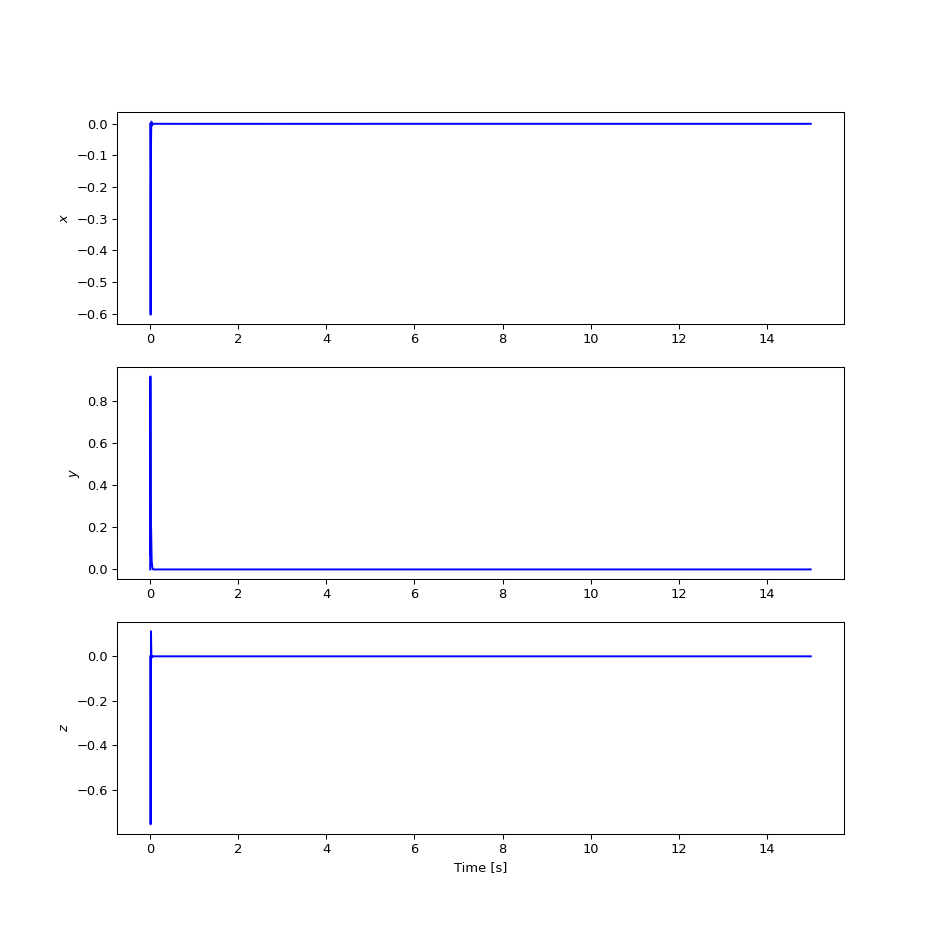

In [9]:
def plot_jacobian_error(time, measured_vel_error):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """    
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,1,1)
    plt.plot(time, measured_vel_error[:,0], 'b-')
    plt.ylabel(r'$x$')
    plt.subplot(3,1,2)
    plt.plot(time, measured_vel_error[:,1], 'b-')
    plt.ylabel(r'$y$')
    plt.subplot(3,1,3)
    plt.plot(time, measured_vel_error[:,2], 'b-')
    plt.ylabel(r'$z$')
    plt.xlabel('Time [s]')

plot_jacobian_error(time, measured_vel_err)

<IPython.core.display.Javascript object>


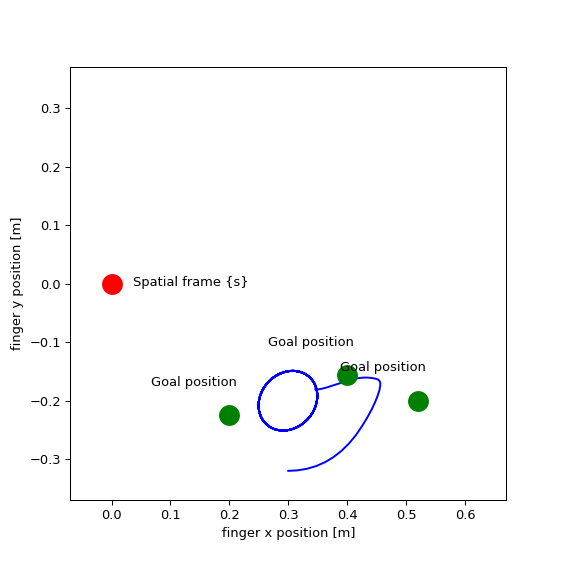

In [10]:
def plot_finger_trajectory(finger_position, ball_positions):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(finger_position[:,0],finger_position[:,1], 'b')
    plt.xlabel('finger x position [m]')
    plt.ylabel('finger y position [m]')
    plt.xlim([-l1-l2+l0-0.05,l0+l1+l2+0.05])
    plt.ylim([-l1-l2-0.05, l1+l2+0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    for ball in ball_positions:
        plt.plot([ball[0]],[ball[1]],'o',markersize=15,color='g')
        ax.annotate('Goal position', xy=(ball[0]-0.2,0.05+ball[1]), xytext=(30,0), textcoords='offset points')
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    
plot_finger_trajectory(measured_finger_position, ball_positions)

<IPython.core.display.Javascript object>


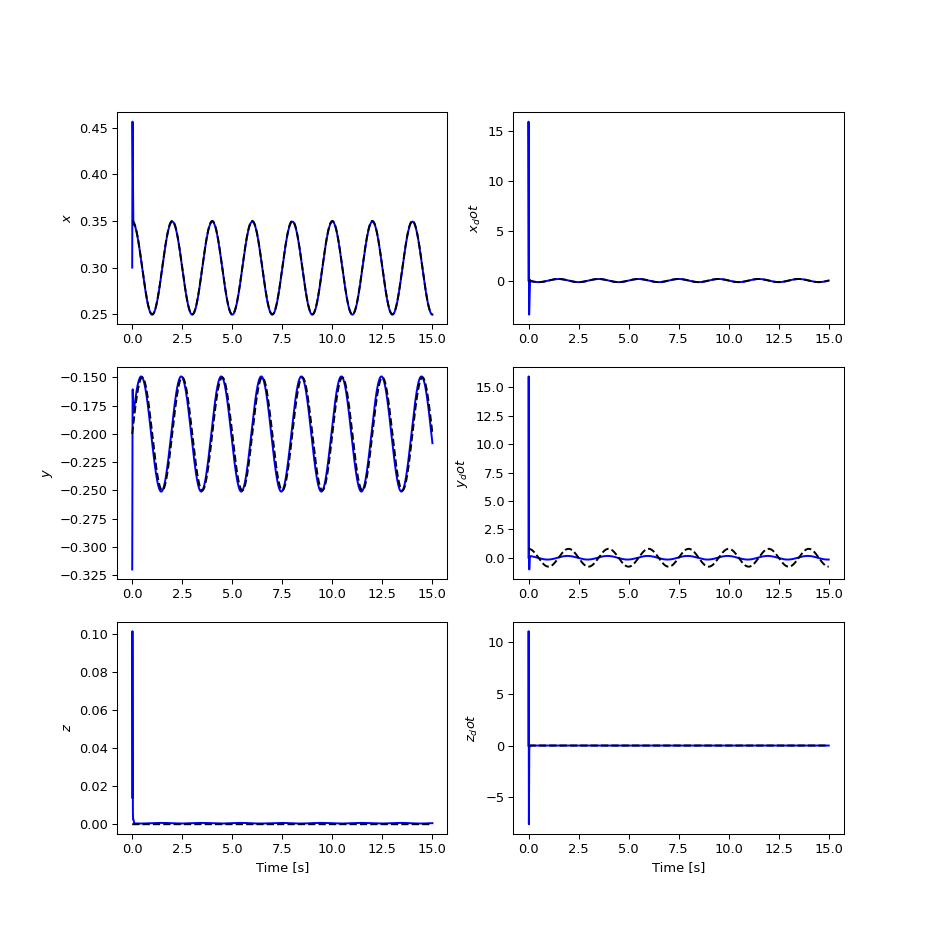

In [11]:
def plot_finger_posvel(time, measured_finger_position, desired_finger_position, measured_finger_velocity, desired_finger_velocity):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """    
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, measured_finger_position[:,0], 'b-', time, desired_finger_position[:,0], '--k')
    plt.ylabel(r'$x$')
    plt.subplot(3,2,3)
    plt.plot(time, measured_finger_position[:,1], 'b-', time, desired_finger_position[:,1], '--k')
    plt.ylabel(r'$y$')
    plt.subplot(3,2,5)
    plt.plot(time, measured_finger_position[:,2], 'b-', time, desired_finger_position[:,2], '--k')
    plt.ylabel(r'$z$')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time,measured_finger_velocity[:,0], 'b-', time, desired_finger_velocity[:,0], '--k')
    plt.ylabel(r'$x_dot$')
    plt.subplot(3,2,4)
    plt.plot(time, measured_finger_velocity[:,1], 'b-', time, desired_finger_velocity[:,1], '--k')
    plt.ylabel(r'$y_dot$')
    plt.subplot(3,2,6)
    plt.plot(time, measured_finger_velocity[:,2], 'b-', time, desired_finger_velocity[:,2], '--k')
    plt.ylabel(r'$z_dot$')
    plt.xlabel('Time [s]')

    
plot_finger_posvel(time, measured_finger_position, desired_finger_position, measured_finger_velocity, desired_finger_velocity)

<IPython.core.display.Javascript object>


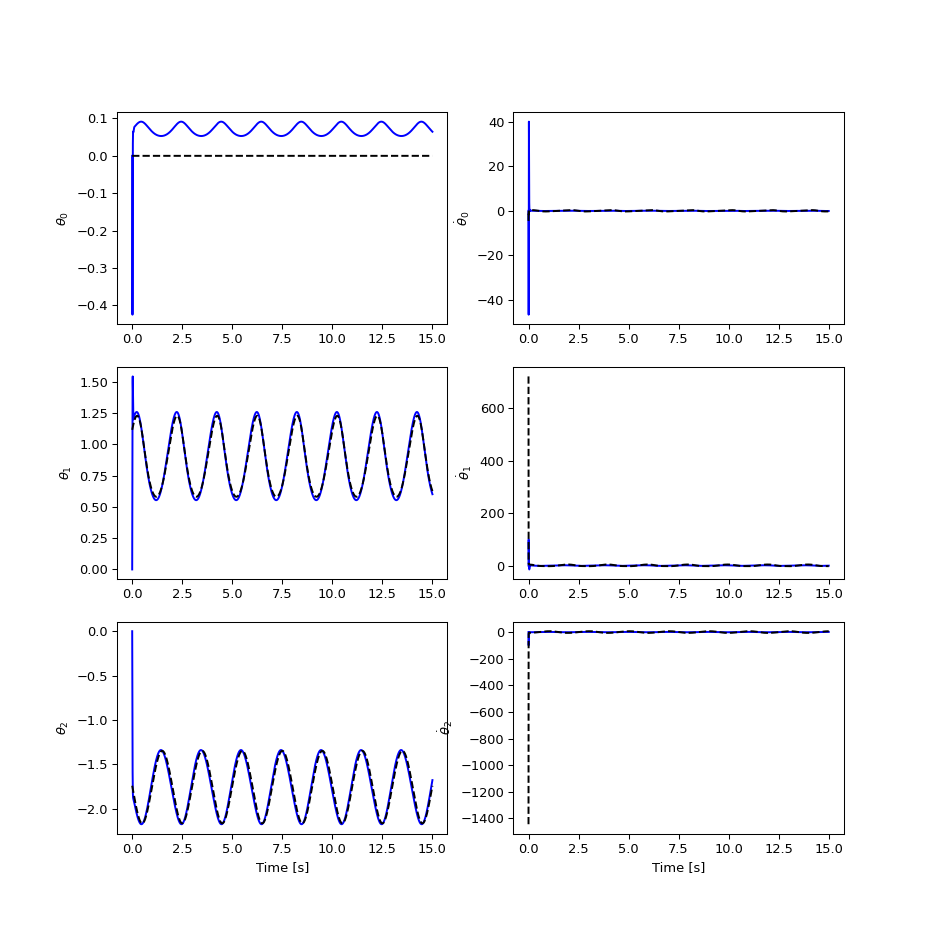

In [12]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'$\theta_0$')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$\theta_1$')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'$\theta_2$')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'$\dot{\theta}_0$')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{\theta}_1$')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'$\dot{\theta}_2$')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time, measured_positions, desired_positions, measured_velocities, reference_velocities)